In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

In [2]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker as mtick
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date, timedelta
import json
import pathlib
# import importlib
%load_ext sql

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
sns.set(
    rc={
        "figure.figsize" : (10, 6.25)
        , "axes.facecolor" : "xkcd:white"
        , "figure.facecolor" : "xkcd:parchment"
        , 'grid.color' : 'xkcd:light gray'
        , 'axes.edgecolor' : 'black'
    }
)

# Change the billboard_observation_date!

In [3]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2025-12-09'

In [4]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [5]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [6]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [7]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [8]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
from upload.rank_by_name import rankings
# from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

["Choosin' Texas",
 'I Got Better',
 "I'm The Problem",
 'What I Want',
 'Just In Case',
 '...',
 'Happy Face',
 'A Song To Sing',
 'Stay A While',
 'Need To',
 'Sober']

In [9]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [10]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most recent song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].max()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|     |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
| 420 |       378 | Choosin' Texas | Ella Langley  | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name    | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-------------|:--------------|:--------------------|---------------------------:|
| 241 |       305 | I Got Better | Morgan Wallen | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
| 205 |       258 | I'm The Problem | Morgan Wallen | Lead artist         |                 

Please enter the song_id or 'New Song'

|     |   song_id | song_name      | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:----------------|:--------------------|---------------------------:|
| 387 |       284 | What Kinda Man | Parker McCollum | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name                 | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:--------------------------|:--------------|:--------------------|---------------------------:|
| 416 |       367 | How Far Does A Goodbye Go | Jason Aldean  | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name              | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-----------------------|:--------------|:--------------------|-----------------------

Please enter the song_id or 'New Song'



In [11]:
# Be aware that some "last week on chart" are one too high. Audit, esp. when the song is marked new in backfillery

# Notes
#### s2a for:

#### Untracked weeks to 0 for


In [11]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(list(new_song_to_rank.keys()))

43 +
['Misery', 'Shit Hill', 'Port A', 'Withdrawals', 'West Texas Degenerate', 'Sunflower', 'Stay A While']


### Add artists on any new songs that aren't in the artist table yet to its CSV

Misery: Treaty Oak Revival(110) ft. Muscadine Bloodline() all male
Shit Hill: Treaty Oak Revival(110)
Port A: Treaty Oak Revival(110)
Withdrawals: Treaty Oak Revival(110) ft. Gannon Fremin & CCREV() all male
West Texas Degenerate: Treaty Oak Revival(110) ft. William Clark Green()
Sunflower: Treaty Oak Revival(110)
Stay A While: Treaty Oak Revival(110)

In [12]:
df_artist = pd.read_csv('source_data/artist.csv')

In [13]:
new_song_artists = [
    'Treaty Oak Revival'
    , 'Muscadine Bloodline'
    , 'Gannon Fremin & CCREV'
    , 'William Clark Green'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
109,110,Treaty Oak Revival,0.0,2024-09-24


In [14]:
df_artist['artist_id'].max()

151

In [16]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [152, 'Muscadine Bloodline', 0, current_date]
                , [153, 'Gannon Fremin & CCREV', 0, current_date]
                , [154, 'William Clark Green', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [17]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2025-12-09


### Add all new songs to the song table CSV

In [19]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [20]:
# Reduce untracked weeks by one for everything being added by backfill
if input('Is this a backfill (1/0)): ') == '1':
    print('-= untracked weeks update running!')
    df_song_raw \
        .loc[
            df_song_raw['song_id'].isin(existing_song_to_rank.keys())
            , 'untracked_weeks_on_chart'
        ] -= 1

Is this a backfill (1/0)): 0


In [21]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[393, 'Misery', 0, '2025-12-09'],
 [394, 'Shit Hill', 0, '2025-12-09'],
 [395, 'Port A', 0, '2025-12-09'],
 [396, 'Withdrawals', 0, '2025-12-09'],
 [397, 'West Texas Degenerate', 0, '2025-12-09'],
 [398, 'Sunflower', 0, '2025-12-09'],
 [399, 'Stay A While', 0, '2025-12-09']]

In [22]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
391,392,Girl You're Taking Home,0.0,2025-12-08
392,393,Misery,0,2025-12-09
393,394,Shit Hill,0,2025-12-09
394,395,Port A,0,2025-12-09
395,396,Withdrawals,0,2025-12-09
396,397,West Texas Degenerate,0,2025-12-09
397,398,Sunflower,0,2025-12-09
398,399,Stay A While,0,2025-12-09


In [23]:
df_song_raw[df_song_raw['song_name'].isin([
    # // If I learn how many weeks it was on the chart before 2024, then add it
    # 'House Party'
    # 'Body Like A Backroad'
])]

,song_id,song_name,untracked_weeks_on_chart,last_update


Scornful Woman: Oliver Anthony Music(103)

In [24]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    # (207, 5)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [25]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
391,392,Girl You're Taking Home,0.0,2025-12-08
392,393,Misery,0,2025-12-09
393,394,Shit Hill,0,2025-12-09
394,395,Port A,0,2025-12-09
395,396,Withdrawals,0,2025-12-09
396,397,West Texas Degenerate,0,2025-12-09
397,398,Sunflower,0,2025-12-09
398,399,Stay A While,0,2025-12-09


In [26]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2025-12-09


#### Add all new songs to the song_to_artist table CSV

Misery: Treaty Oak Revival(110) ft. Muscadine Bloodline(152) all male
Shit Hill: Treaty Oak Revival(110)
Port A: Treaty Oak Revival(110)
Withdrawals: Treaty Oak Revival(110) ft. Gannon Fremin & CCREV(153) all male
West Texas Degenerate: Treaty Oak Revival(110) ft. William Clark Green(154)
Sunflower: Treaty Oak Revival(110)
Stay A While: Treaty Oak Revival(110)

In [28]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

In [29]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [393, 110, '', '']
    , [393, 152, '', 1]
    , [394, 110, '', '']
    , [395, 110, '', '']
    , [396, 110, '', '']
    , [396, 153, '', 1]
    , [397, 110, '', '']
    , [397, 154, '', 1]
    , [398, 110, '', '']
    , [399, 110, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
print(
    len(array_new_s2a)
    , 'additions ending in song id'
    , array_new_s2a[-1][1]
)

10 additions ending in song id 399


In [30]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
507,399-Lead artist-,399,110,Lead artist,,,2025-12-09


In [31]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2025-12-09


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [32]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1: # Can factor out input if I assume we won't have two of the same name added in the same week ever
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2025-12-09-36', '2025-12-09', 36, 395, '2025-12-09'],
 ['2025-12-09-37', '2025-12-09', 37, 396, '2025-12-09'],
 ['2025-12-09-38', '2025-12-09', 38, 397, '2025-12-09'],
 ['2025-12-09-45', '2025-12-09', 45, 398, '2025-12-09'],
 ['2025-12-09-48', '2025-12-09', 48, 399, '2025-12-09']]

In [33]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2025-12-09


## Push to duckdb

In [34]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

#### TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

In [35]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

## Run the ranking SQL script

I like to run through at n_weeks_for_recent = 1, then again at = 20

In [48]:
# Set parameters for the ranking
n_weeks_for_recent = 20 # Arbitrary definition of recency, aligned with when bottom half of the chart
    # Compare to: 1, 13, 20, 26, 52
floor_avg_weeks = 1.67
weeks_lookback = 52 # Arbitrary lookback // data starts 2024-01-01
value_metric = 'recent_weeks_main_artist'

In [49]:
with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(
                    sql_file.read().format(
                        weeks_ago = str(weeks_ago)
                        , n_weeks_for_recent = str(n_weeks_for_recent)
                    )
                )
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(
                    sql_file.read().format(
                        weeks_ago = str(weeks_ago)
                        , n_weeks_for_recent = str(n_weeks_for_recent)
                    )
                )
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [50]:
# Limit to just artists with currently enough song-weeks over the lookback
top_artists = list(
    df_artist_ranking[
        (df_artist_ranking[value_metric] > floor_avg_weeks * n_weeks_for_recent)
        & (df_artist_ranking['weeks_ago'] == 0)
    ]['artist_id']
)

order_of_artists = df_artist_ranking[
    (df_artist_ranking['artist_id'].isin(top_artists))
    & (df_artist_ranking['weeks_ago'] == 0)
].pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = value_metric
).sort_values(0, ascending = False).index.to_list()

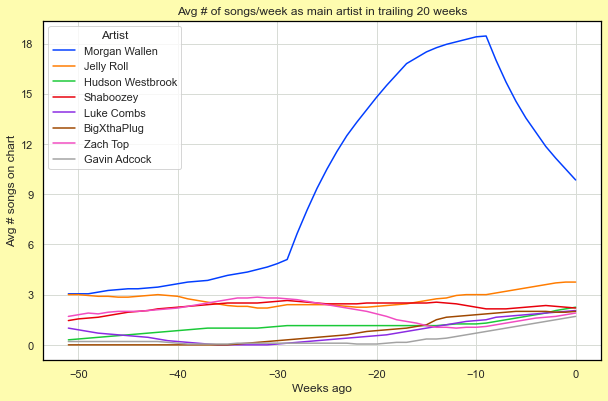

In [51]:
value_metric = 'recent_weeks_main_artist' # 'recent_weeks_artist' to include featured song weeks
graph = sns.lineplot(
    data = df_artist_ranking[
        df_artist_ranking['artist_id'].isin(top_artists)
      ].pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = value_metric
      ).loc[order_of_artists].fillna(np.inf).T 
      / n_weeks_for_recent
    , dashes = False
    , palette = 'bright'
)

more_than_one_week = 0
if n_weeks_for_recent > 1:
    more_than_one_week += 1
    
graph.set(
    title = 'Avg # of songs/week as main artist in trailing {} week{}'.format(
        n_weeks_for_recent
        , ''.join((more_than_one_week * ['s']))
    )
    , ylabel = 'Avg # songs on chart'
    , xlabel = 'Weeks ago'
)

plt.legend(title = 'Artist')
graph.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

In [52]:
# Current artist rankings
pd.set_option('display.max_rows', 115)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact \
    .loc[:, 1 : len(cols) - 2 ][
        (df_artist_ranking['weeks_ago'] == 0)
        # & (df_artist_ranking['artist_name'].isin(current_artists))
].head(40)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Morgan Wallen,0,197,197,197,754,819,868,20,20,20,44,47,49,1.0,1.0,1.0,1,2024-01-06
1,Jelly Roll,0,18,75,77,179,334,385,1,4,5,10,16,19,14.0,14.0,3.0,3,2024-01-06
2,Hudson Westbrook,0,45,45,45,85,85,85,4,4,4,4,4,4,11.0,11.0,11.0,11,2024-11-12
3,Shaboozey,0,43,44,44,169,172,172,3,4,4,8,9,9,3.0,3.0,1.0,1,2024-04-26
4,Luke Combs,0,29,41,57,198,221,296,3,4,6,14,15,20,4.0,4.0,2.0,2,2024-01-06
5,BigXthaPlug,0,40,40,40,57,57,60,8,8,8,8,8,9,6.0,6.0,1.0,1,2024-07-02
6,Zach Top,0,38,38,38,134,134,134,4,4,4,7,7,7,19.0,19.0,6.0,6,2024-08-23
7,Gavin Adcock,0,34,34,34,40,40,40,2,2,2,3,3,3,14.0,14.0,14.0,14,2024-10-02
8,Tucker Wetmore,0,30,30,31,114,114,115,2,2,3,5,5,6,14.0,14.0,6.0,6,2024-03-05
9,Megan Moroney,0,28,28,28,165,181,181,3,3,3,10,11,11,8.0,8.0,8.0,8,2024-01-06


In [53]:
# As above, but changes rather than current status
pd.options.display.float_format = '{:+,.0f}'.format
df_artist_ranking_change = df_artist_ranking.copy()[
    (df_artist_ranking['weeks_ago'] == 0)
    & (df_artist_ranking['recent_weeks_artist'] != 0)
]
df_artist_ranking_change.drop(['artist_debut_date_in_data'], axis = 1, inplace = True)
ranking_cols = list(df_artist_ranking_change.columns)

for row in df_artist_ranking_change.iterrows():
    this_artist = row[1]['artist_id']
    this_change_row = df_artist_ranking_change[
        df_artist_ranking_change['artist_id'] == this_artist
    ]
    row_last_week = df_artist_ranking[
        (df_artist_ranking['weeks_ago'] == -1)
        & (df_artist_ranking['artist_id'] == this_artist)
    ]
    for col_name, val_this_week in row[1][3:].items():
        val_last_week = np.array(row_last_week[col_name])[0]
        val_change = round(val_this_week - val_last_week, 0)
        
        if col_name in ['artist_rank', 'recent_peak_position']:
            if val_change > 0: # Higher numbers are "lower" on the chart
                str_change = '↘ ' + str(round(val_change))
            elif val_change == 0:
                str_change = ''
            elif val_change < 0: # Lower numbers are "higher" on the chart
                str_change = '↗ ' + str(round(abs(val_change)))
                
        else:
            val_change = val_this_week - val_last_week
            if val_change > 0:
                str_change = '+' + str(val_change)
            elif val_change == 0:
                str_change = ''
            elif val_change < 0:
                str_change = str(val_change)
        
        df_artist_ranking_change.loc[this_change_row.index[0], col_name] = str_change


df_changes = df_artist_ranking_change[[
    'artist_name'
    , 'artist_rank'
    , 'recent_weeks_main_artist'
    , 'recent_weeks_lead_artist'
    , 'recent_weeks_artist'
    , 'recent_num_songs_main_artist'
    , 'recent_num_songs_lead_artist'
    , 'recent_num_songs_artist'
    , 'recent_peak_position'
]]

df_changes.columns = [
    'Artist'
    , 'Rank'
    , 'Weeks (Main)' # TODO: multilevel column index
    , 'Weeks (Lead)'
    , 'Weeks (Any)'
    , 'Songs (Main)'
    , 'Songs (Lead)'
    , 'Songs (Any)'
    , 'Recent Peak Position'
]

df_changes.style.set_properties(**{'text-align': 'left'})
# df_changes.style.set_sticky(axis = 1) # TOFIX

,Artist,Rank,Weeks (Main),Weeks (Lead),Weeks (Any),Songs (Main),Songs (Lead),Songs (Any),Recent Peak Position
0,Morgan Wallen,,-13,-13,-13,-1,-1,-1,
1,Jelly Roll,,,-1,,,,,
2,Hudson Westbrook,↗ 1,+2,+2,+2,,,,
3,Shaboozey,↘ 1,-1,-1,-1,,,,
4,Luke Combs,,+1,+2,+1,,,,
5,BigXthaPlug,,+1,+1,+1,,,,
6,Zach Top,,+2,+2,+2,,,,
7,Gavin Adcock,,+2,+2,+2,,,,
8,Tucker Wetmore,,,,,,,,↗ 9
9,Megan Moroney,,+1,+1,+1,,,,


Good place to go back and shift the n_weeks_lookback

In [54]:
%%sql df_weeks_for_artist <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
    , s2a.artist_id
    , art.artist_name
    , s2a.relationship_type
    , art.pct_female
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
LEFT JOIN raw_db.billboard.song_to_artist s2a
    ON br.song_id = s2a.song_id
LEFT JOIN raw_db.billboard.artist art
    ON s2a.artist_id = art.artist_id
ORDER BY 1 ASC

In [55]:
with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/cumulative_pct_female.sql') as sql_file:
        cumulative_pct_female = conn.sql(sql_file.read())
        df_cumulative_pct_female = pd.DataFrame(
            data = cumulative_pct_female.fetchall()
            , columns = cumulative_pct_female.columns
        )

In [56]:
df_by_reln_type = df_weeks_for_artist.groupby(
        ['billboard_observation_date', 'relationship_type']
    ).agg(['mean', 'count'])['pct_female'].reset_index()
df_by_reln_type['wtd_avg_numerator'] = df_by_reln_type['mean'] * df_by_reln_type['count']

df_all_credits = df_by_reln_type.groupby('billboard_observation_date').sum()
df_all_credits['mean'] = df_all_credits['wtd_avg_numerator'] / df_all_credits['count']
df_all_credits.reset_index(inplace = True)
df_all_credits['relationship_type'] = 'All credited artists'

df_mains = df_by_reln_type[
    df_by_reln_type['relationship_type'].isin(['Lead artist', 'Other main artist'])
].groupby('billboard_observation_date').sum()
df_mains['mean'] = df_mains['wtd_avg_numerator'] / df_mains['count']
df_mains.reset_index(inplace = True)
df_mains['relationship_type'] = 'All main artists'

col_order = [
    'billboard_observation_date'
    , 'relationship_type'
    , 'mean'
    , 'count'
    , 'wtd_avg_numerator'
]

df_pct_female = pd.concat([
    df_by_reln_type
    , df_all_credits[col_order]
    , df_mains[col_order]
])

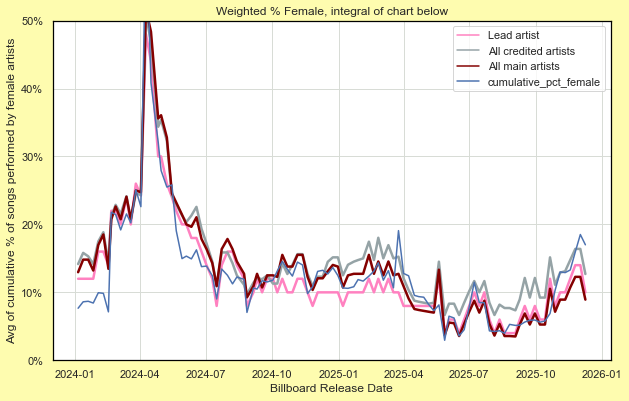

In [57]:
palette = {
    'Lead artist' : 'xkcd:pink'
    , 'All main artists' : 'xkcd:dark red'
    , 'All credited artists' : 'xkcd:cool gray'
}

graph = sns.lineplot(
    data = df_pct_female[
        df_pct_female['relationship_type'].isin(palette.keys())
    ]
    , x = 'billboard_observation_date'
    , y = 'mean'
    , hue = 'relationship_type'
    , palette = palette
    , linewidth = 2.5
).set(
    title = '% of Chart Female by Credit Type'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = '% Female'
    , ylim = [0, 0.5]
)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend(
    [handles[idx] for idx in order],[labels[idx] for idx in order]
    # + ['Rank wtd for main artists']
    , title = 'Role on Song'
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

# TODO: integrate with above, maybe replace all-main line
sns.lineplot(
    data = df_cumulative_pct_female.groupby(['billboard_observation_date']).mean()[[
        'cumulative_pct_female'
    ]]
).set(ylim = [0, 0.50])
plt.title('Weighted % Female, integral of chart below')
plt.xlabel('Billboard Release Date')
plt.ylabel('Avg of cumulative % of songs performed by female artists')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

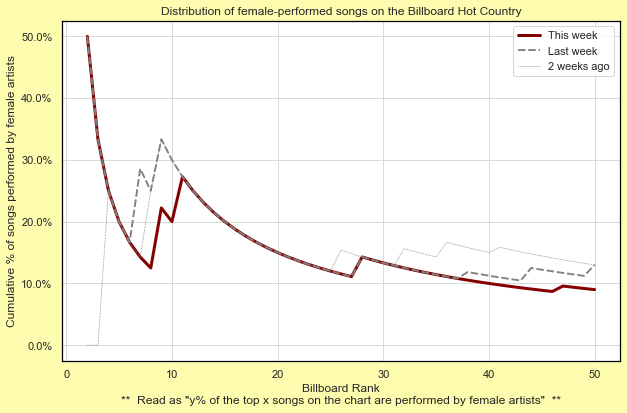

In [58]:
weeks_to_show = 3
graph = sns.lineplot(
    data = df_cumulative_pct_female[
        (df_cumulative_pct_female['billboard_rank'] > 1)
        & (
            pd.to_datetime(df_cumulative_pct_female['billboard_observation_date'])
            > pd.to_datetime(billboard_observation_date) 
                + pd.DateOffset(days = -7 * (weeks_to_show - 1) - 3)
          )
      ]
    , y = 'cumulative_pct_female'
    , x = 'billboard_rank'
    , palette = ['xkcd:dark red', 'grey', 'grey'] # to modularize past three
    , hue = 'billboard_observation_date'
    , size = 'billboard_observation_date'
    , style = 'billboard_observation_date'
)

plt.legend(['This week', 'Last week', '2 weeks ago'])
plt.title('Distribution of female-performed songs on the Billboard Hot Country')
plt.xlabel(
    'Billboard Rank\n'
    + '**  Read as "y% of the top x songs on the chart are performed by female artists"  **'
)
plt.ylabel('Cumulative % of songs performed by female artists')
graph.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.1%}'))

In [59]:
credit_type_to_linestyle = {
    'Lead artist' : 'solid'
    , 'Other main artist' : 'dashed'
    , 'Featured artist' : 'dotted'
}

In [60]:
# TODO enrich with n_songs from above
df_weeks_for_artist[
    df_weeks_for_artist['billboard_observation_date'] == billboard_observation_date
].groupby('artist_name').count().iloc[:,1].loc[
    #lambda x: x >= 1
    lambda x: x > 1
].sort_values(ascending = False)

artist_name
Treaty Oak Revival    9
Morgan Wallen         6
Ella Langley          3
Hudson Westbrook      3
Jelly Roll            3
BigXthaPlug           2
Cody Johnson          2
Gavin Adcock          2
Luke Combs            2
Megan Moroney         2
Post Malone           2
Zach Top              2
Name: song_id, dtype: int64

Beautiful Things: Megan Moroney(4)
Time's Ticking: Justin Moore(51)

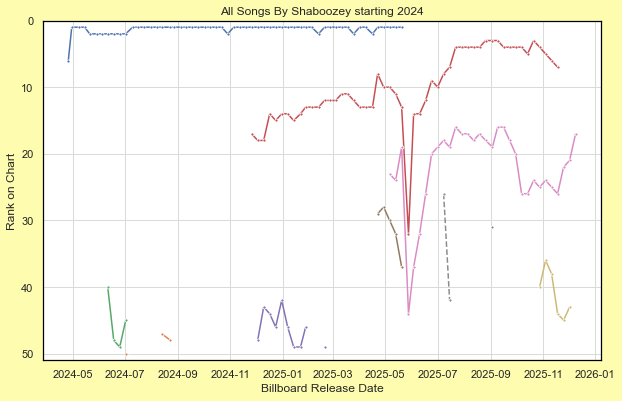

In [75]:
# For now, manual artist name selection
# TODO: Create charts for every artist on this week's chart at once
artist_name = 'Shaboozey'

df_weeks_this_artist = df_weeks_for_artist.query(
    f"artist_name == '{artist_name}'"
)

## TODO add groupby
# if df_weeks_this_artist['artist_id'].count().count() > 1:
#     this_artist_id = input("Please input artist ID for differentiation")
#     df_weeks_this_artist[
#         df_weeks_this_artist[artist_id] == this_artist_id
#     ]

for _, row in df_weeks_this_artist.pivot( # TODO no pivot to support legend in char 'song_name'
    index = 'song_id'
    , columns = 'billboard_observation_date' #TODO: weeks ago
    , values = 'billboard_rank'
).fillna(
    np.inf # suppresses only if a different song is on the chart in any week within this song's gap
).iterrows():
    graph = sns.lineplot(
        data = row
        , linestyle = credit_type_to_linestyle[
            df_weeks_this_artist[
                df_weeks_this_artist['song_id'] == row.name
            ].groupby('relationship_type').count().iloc[0].name
        ]
        , marker = '.'
    )
    
graph.set(
    title = f'All Songs By {artist_name} starting 2024'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = 'Rank on Chart'
    , ylim = [0, 51]
)
graph.axes.invert_yaxis()

In [72]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = billboard_observation_date
comparison_observation_date = '2025-10-14'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬───────────────┬─────────────────────┬────────────────┐
│ song_id │   song_name   │  lead_artist_name   │ ranking_before │
│  int32  │    varchar    │       varchar       │     int32      │
├─────────┼───────────────┼─────────────────────┼────────────────┤
│     297 │ Backup Plan   │ Bailey Zimmerman    │             24 │
│     294 │ Brunette      │ Tucker Wetmore      │             29 │
│     280 │ Hands Of Time │ Eric Church         │             37 │
│     373 │ 15 Minutes    │ Luke Combs          │             46 │
│     374 │ People Hatin' │ The Red Clay Strays │             48 │
└─────────┴───────────────┴─────────────────────┴────────────────┘



In [68]:
# TODO consider adding a measurement start date column
    # for Friday of each week based on observation date

In [64]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

In [65]:
# For reversion to standard if you scroll back up
sns.set(
    rc={
        "figure.figsize" : (10, 6.25)
        , "axes.facecolor" : "xkcd:white"
        , "figure.facecolor" : "xkcd:parchment"
        , 'grid.color' : 'xkcd:light gray'
        , 'axes.edgecolor' : 'black'
    }
)

In [66]:
sns.set(
    rc={
        "figure.figsize" : (22, 13.75)
        , "axes.facecolor" : "xkcd:white"
        , "figure.facecolor" : "xkcd:parchment"
        , 'grid.color' : 'xkcd:light gray'
        , 'axes.edgecolor' : 'black'
    }
)

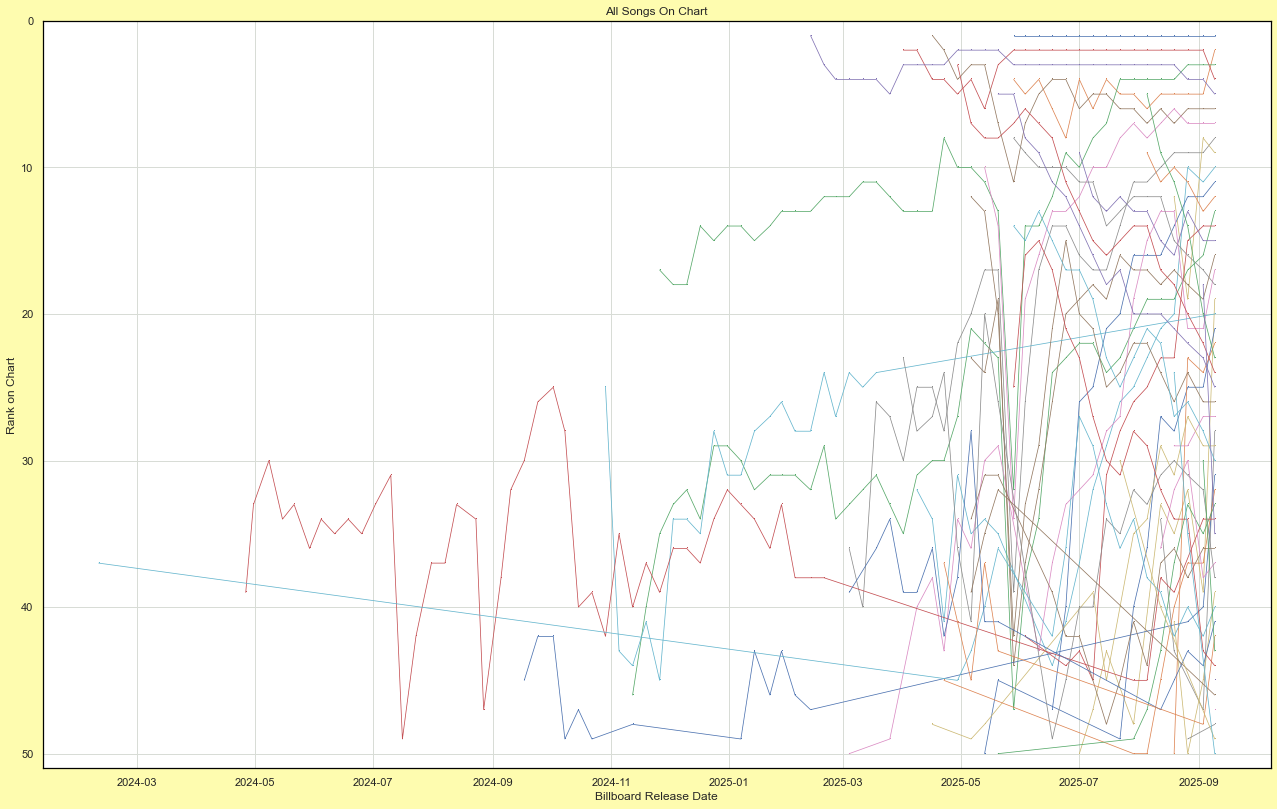

In [67]:
for _, row in df_weeks.query(
    # f"billboard_observation_date == '2024-09-10'"
    f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(
        np.inf # Not working fully to show gaps as missing
    )
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        , marker = ','
        , dashes = False
        , linewidth = 0.75
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    )#.set_title(this_song.reset_index()['song_name'][0])
    
graph.set(
    title = f'All Songs On Chart'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = 'Rank on Chart'
    , ylim = [0, 51]
)
graph.axes.invert_yaxis()

In [59]:
# TODO maybe: Each artist or song on its own tile, rather than overlapped